In [12]:
!apt-get update
!apt-get install python3.12
!pip install autodyn
!pip install pysindy
!pip install latexify_py
!pip --force-reinstall matplotlib

!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.12 2

!python --version


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Ign:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:11 https://r2u.stat.illinois.edu/ubuntu jammy Release
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

In [13]:
from autodyn.core import dynamical as dyn
from autodyn.models.canonical.standard import (
    lorenz,
    consensus,
    single_hopf,
    controlled_hopf,
)
from autodyn.core.network import connectivity
import matplotlib.pyplot as plt

# Setup a Simple Lorenz System
First, we'll set up a Lorenz system with known ground-truth coefficients.
Then we'll plot its state in phase space.

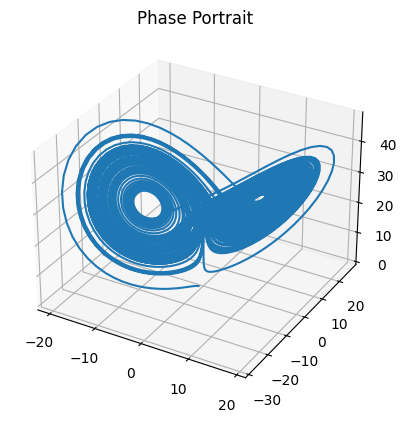

In [14]:
lorenz_sys = dyn.system(lorenz, D=3)
lorenz_params = {'sigma':10, 'rho':28, 'beta':8/3}
lorenz_sys.simulate(T=100, dt=0.01, **lorenz_params)
lorenz_sys.plot_phase()

Then we'll plot the projection of this trajectory along the three independent axes - corresponding to individual, separate measurements.

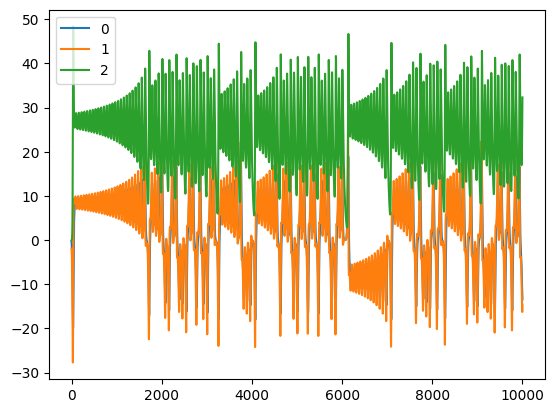

In [15]:
[plt.plot(lorenz_sys.raster[...,ii],label=ii) for ii in range(3)]
plt.legend()
true_lorenz = lorenz_sys.raster

## RNN Sequence Learning
First, we'll implement an RNN to learn the *sequence* that we observed.
Code based off of:

In [16]:
# Let's build a Model
# First in PyTorch
import torch
from torch import nn
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import numpy as np

def visualize_3d(obs=None, noiseless_traj=None,times=None, trajs=None, save=None, title=''):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    if title is not None:
      ax.set_title('Trajectory\n'+title)

    if noiseless_traj is not None:
      z = np.array([o for o in noiseless_traj])
      z = np.reshape(z, [-1,3])
      for i in range(len(z)):
        ax.plot(z[i:i+10, 0], z[i:i+10, 1], z[i:i+10, 2], color=plt.cm.jet(i/len(z)/1.6))

    if obs is not None:
      z = np.array([o for o in obs])
      z = np.reshape(z, [-1,3])
      ax.scatter(z[:,0], z[:,1], z[:,2], marker='.', color='k', alpha=0.5, linewidths=0, s=45)

    if trajs is not None:
      z = np.array([o for o in trajs])
      z = np.reshape(z, [-1,3])
      for i in range(len(z)):
        ax.plot(z[i:i+10, 0], z[i:i+10, 1], z[i:i+10, 2], color='r', alpha=0.3)

    fig.canvas.draw()
    fig.canvas.flush_events()
    if save is not None:
        plt.savefig(save+'.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
    plt.show()


class fcRNN(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size, n_layers):
    super(fcRNN, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.rnn = nn.RNN(input_size,
                      hidden_dim, n_layers,
                      nonlinearity='relu',
                      batch_first=True) # RNN hidden units
    self.fc = nn.Linear(hidden_dim, output_size) # output layer

  def forward(self, x):
    bs, _, _ = x.shape
    h0 = torch.zeros(self.n_layers, bs, self.hidden_dim).requires_grad_().to(device)
    out, hidden = self.rnn(x, h0.detach())
    out = out.view(bs, -1, self.hidden_dim)
    out = self.fc(out)
    return out[:, -1, :]

def create_inout_sequences(input_data, tw):
    train_data = []
    labels = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        train_data.append(torch.FloatTensor(train_seq).squeeze(1).unsqueeze(0))
        labels.append(torch.FloatTensor(train_label).squeeze(1).unsqueeze(0))

    return torch.cat(train_data, 0), torch.cat(labels, 0)


system = "lorenz"  # choose "lorenz" or "fixed_point"
if system == "lorenz":
    observations = true_lorenz
elif system == "fixed_point":
    observations = true_fixed_point

feature_size = observations.shape[1]
model = fcRNN(feature_size, 128, feature_size, 2)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print("Model has a total of {0} parameters.".format(pytorch_total_params))

def model_predict(pred_len, model, initial_condition):
    test_inputs = initial_condition
    pred_traj = []
    for i in range(train_window):
        pred_traj.append(test_inputs[i])

    with torch.no_grad():
        for i in range(pred_len):
            seq = torch.tensor(np.array(pred_traj).squeeze()[-train_window:])
            model_out = model(seq.unsqueeze(0)).squeeze().detach().numpy().reshape(-1)
            pred_traj.append(model_out)
    pred_traj = np.array(pred_traj)
    return pred_traj


train_window = 10
# generating training data and labels for RNN
data_train, labels = create_inout_sequences(observations, train_window)
data_train.shape
epochs = 10
loss_arr = []
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# training loop
for i in range(epochs):
    print(i)
    if i > 1200:
        optimizer.param_groups[0]['lr'] = 1e-3
    optimizer.zero_grad()
    y_pred = model(data_train)
    #print(y_pred.shape)
    loss = loss_function(y_pred, labels.squeeze())
    loss.backward()
    optimizer.step()

    loss_arr.append(loss.item())
    if i == epochs:
        print(f'epoch: {i:3} loss: {loss_arr[-1]:10.8f}')
        pred_len = 990
        test_inputs = data_train[0].squeeze().detach().numpy()
        pred_traj = model_predict(pred_len, model, test_inputs)
        save_name = "PNG/"+system+str(i)

        if system == "lorenz":
            visualize_3d(obs=true_lorenz,
                         noiseless_traj=pred_traj)
        elif system == "fixed_point":
            visualize_2d(pred_y=np.expand_dims(pred_traj, 1), true_y=true_fixed_point)

print(f'epoch: {i:3} loss: {loss_arr[-1]:10.10f}')

Model has a total of 50435 parameters.
0
1
2
3
4
5
6
7
8
9
epoch:   9 loss: 213.7189636230


Notice here that we have a total of 50,000+ parameters.
Each of the parameters reflect some weight of

## SINDy
Unlike RNN/Transformers, the goal of SINDy is not to learn properties of the training sequence - it's to find a parsominious dynamical system *underlying* the trajectory.

In [18]:
import pysindy as ps

model = ps.SINDy()
model.fit(true_lorenz, t=0.01)
model.print()
print(lorenz_params)

ContextualVersionConflict: (importlib-metadata 8.2.0 (/usr/local/lib/python3.10/dist-packages), Requirement.parse('importlib-metadata<8.0.0,>=7.1.0'), {'derivative'})